In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = 2
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 30  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    image=np.clip(image,a_min=10000,a_max=50000)
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



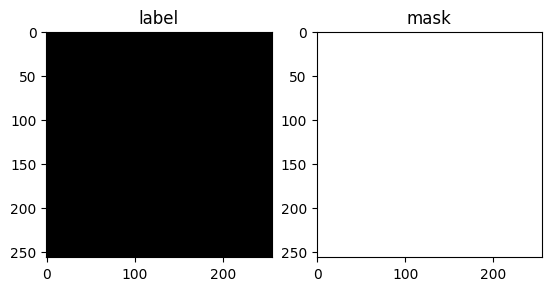

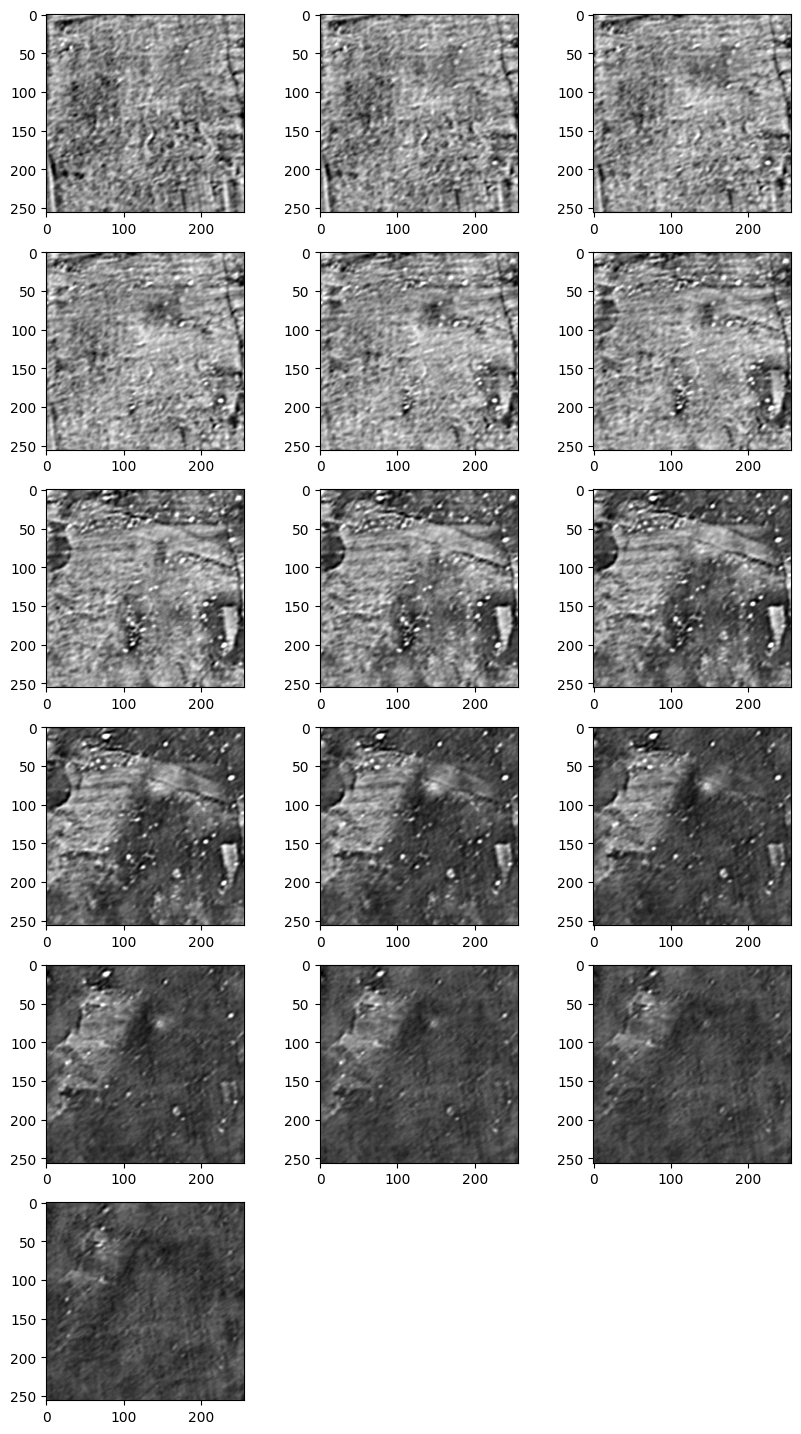

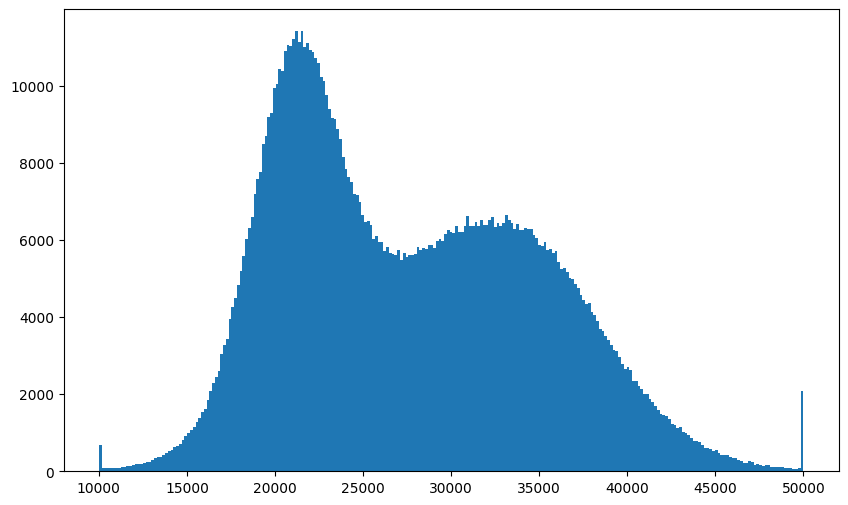

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = random.randint(0, CFG.random_shift)
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 0.9622: 100%|██████████| 174/174 
Val Loss: 0.7737: 100%|██████████| 49/49 [00:15<00:00,  3.19it/s]               


FBeta : 0.3899	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5824: 100%|██████████| 174/174 
Val Loss: 0.5521: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]               


FBeta : 0.3952	SAVED MODEL



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4768: 100%|██████████| 174/174 
Val Loss: 0.5689: 100%|██████████| 49/49 [00:15<00:00,  3.18it/s]               


FBeta : 0.0612



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4408: 100%|██████████| 174/174 
Val Loss: 0.5217: 100%|██████████| 49/49 [00:15<00:00,  3.23it/s]               


FBeta : 0.4263	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4199: 100%|██████████| 174/174 
Val Loss: 0.4812: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.4866	SAVED MODEL



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3981: 100%|██████████| 174/174 
Val Loss: 0.5920: 100%|██████████| 49/49 [00:15<00:00,  3.22it/s]               


FBeta : 0.4347



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3850: 100%|██████████| 174/174 
Val Loss: 0.5098: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.4864



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3720: 100%|██████████| 174/174 
Val Loss: 0.5647: 100%|██████████| 49/49 [00:14<00:00,  3.27it/s]               


FBeta : 0.4164



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3636: 100%|██████████| 174/174 
Val Loss: 0.4752: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5155	SAVED MODEL



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3516: 100%|██████████| 174/174 
Val Loss: 0.4300: 100%|██████████| 49/49 [00:15<00:00,  3.26it/s]               


FBeta : 0.5729	SAVED MODEL



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3417: 100%|██████████| 174/174
Val Loss: 0.5009: 100%|██████████| 49/49 [00:15<00:00,  3.26it/s]               


FBeta : 0.4547



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3310: 100%|██████████| 174/174
Val Loss: 0.4388: 100%|██████████| 49/49 [00:15<00:00,  3.27it/s]               


FBeta : 0.5433



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3220: 100%|██████████| 174/174
Val Loss: 0.4917: 100%|██████████| 49/49 [00:15<00:00,  3.26it/s]               


FBeta : 0.5115



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3136: 100%|██████████| 174/174
Val Loss: 0.4487: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5643



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3007: 100%|██████████| 174/174
Val Loss: 0.4933: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5071



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2916: 100%|██████████| 174/174
Val Loss: 0.5781: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.4340



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2805: 100%|██████████| 174/174
Val Loss: 0.5006: 100%|██████████| 49/49 [00:15<00:00,  3.26it/s]               


FBeta : 0.5711



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2764: 100%|██████████| 174/174
Val Loss: 0.4692: 100%|██████████| 49/49 [00:15<00:00,  3.23it/s]               


FBeta : 0.5906	SAVED MODEL



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2680: 100%|██████████| 174/174
Val Loss: 0.4935: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5906	SAVED MODEL



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2582: 100%|██████████| 174/174
Val Loss: 0.6567: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.4249



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2456: 100%|██████████| 174/174
Val Loss: 0.4848: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5799



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2399: 100%|██████████| 174/174
Val Loss: 0.4882: 100%|██████████| 49/49 [00:14<00:00,  3.27it/s]               


FBeta : 0.5336



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2333: 100%|██████████| 174/174
Val Loss: 0.5224: 100%|██████████| 49/49 [00:15<00:00,  3.24it/s]               


FBeta : 0.5999	SAVED MODEL



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2253: 100%|██████████| 174/174
Val Loss: 0.4577: 100%|██████████| 49/49 [00:15<00:00,  3.17it/s]               


FBeta : 0.6071	SAVED MODEL



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2177: 100%|██████████| 174/174
Val Loss: 0.4790: 100%|██████████| 49/49 [00:15<00:00,  3.22it/s]               


FBeta : 0.5690



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2101: 100%|██████████| 174/174
Val Loss: 0.4939: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]               


FBeta : 0.5896



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2061: 100%|██████████| 174/174
Val Loss: 0.6074: 100%|██████████| 49/49 [00:15<00:00,  3.23it/s]               


FBeta : 0.5603



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2000: 100%|██████████| 174/174
Val Loss: 0.5120: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]               


FBeta : 0.5598



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1959: 100%|██████████| 174/174
Val Loss: 0.5038: 100%|██████████| 49/49 [00:14<00:00,  3.27it/s]               


FBeta : 0.5730



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1956: 100%|██████████| 174/174
Val Loss: 0.5065: 100%|██████████| 49/49 [00:15<00:00,  3.26it/s]               


FBeta : 0.5936

fold: 1


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0206: 100%|██████████| 177/177 
Val Loss: 0.6861: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.3636	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6617: 100%|██████████| 177/177 
Val Loss: 0.3476: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.4286	SAVED MODEL



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5210: 100%|██████████| 177/177 
Val Loss: 0.2855: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]               


FBeta : 0.5128	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4789: 100%|██████████| 177/177 
Val Loss: 0.3996: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.3536



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4547: 100%|██████████| 177/177 
Val Loss: 0.2988: 100%|██████████| 46/46 [00:14<00:00,  3.22it/s]               


FBeta : 0.4809



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4380: 100%|██████████| 177/177 
Val Loss: 0.2812: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.4401



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4190: 100%|██████████| 177/177 
Val Loss: 0.3014: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]               


FBeta : 0.3675



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4071: 100%|██████████| 177/177 
Val Loss: 0.2694: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5590	SAVED MODEL



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3927: 100%|██████████| 177/177 
Val Loss: 0.2747: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]               


FBeta : 0.5160



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3841: 100%|██████████| 177/177 
Val Loss: 0.2751: 100%|██████████| 46/46 [00:14<00:00,  3.22it/s]               


FBeta : 0.4987



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3705: 100%|██████████| 177/177
Val Loss: 0.2883: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.5511



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3525: 100%|██████████| 177/177
Val Loss: 0.2515: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]               


FBeta : 0.5815	SAVED MODEL



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3469: 100%|██████████| 177/177
Val Loss: 0.2742: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]               


FBeta : 0.6023	SAVED MODEL



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3369: 100%|██████████| 177/177
Val Loss: 0.2762: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5538



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3251: 100%|██████████| 177/177
Val Loss: 0.2923: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5621



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3139: 100%|██████████| 177/177
Val Loss: 0.2965: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5854



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3027: 100%|██████████| 177/177
Val Loss: 0.2783: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.5653



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2938: 100%|██████████| 177/177
Val Loss: 0.2810: 100%|██████████| 46/46 [00:14<00:00,  3.22it/s]               


FBeta : 0.6045	SAVED MODEL



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2796: 100%|██████████| 177/177
Val Loss: 0.2966: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.5460



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2735: 100%|██████████| 177/177
Val Loss: 0.3036: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.5886



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2633: 100%|██████████| 177/177
Val Loss: 0.2811: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.6026



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2505: 100%|██████████| 177/177
Val Loss: 0.3009: 100%|██████████| 46/46 [00:14<00:00,  3.12it/s]               


FBeta : 0.5997



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2431: 100%|██████████| 177/177
Val Loss: 0.2877: 100%|██████████| 46/46 [00:14<00:00,  3.11it/s]               


FBeta : 0.5966



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2365: 100%|██████████| 177/177
Val Loss: 0.3086: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6081	SAVED MODEL



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2286: 100%|██████████| 177/177
Val Loss: 0.3150: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6090	SAVED MODEL



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2205: 100%|██████████| 177/177
Val Loss: 0.3219: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6054



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2140: 100%|██████████| 177/177
Val Loss: 0.3033: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.5917



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2084: 100%|██████████| 177/177
Val Loss: 0.3056: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.5854



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2056: 100%|██████████| 177/177
Val Loss: 0.3129: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6072



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2013: 100%|██████████| 177/177
Val Loss: 0.3193: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6130	SAVED MODEL

fold: 2


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0097: 100%|██████████| 177/177 
Val Loss: 0.9297: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]               


FBeta : 0.4597	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5870: 100%|██████████| 177/177 
Val Loss: 0.7083: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.4269



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4495: 100%|██████████| 177/177 
Val Loss: 0.6384: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5127	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4131: 100%|██████████| 177/177 
Val Loss: 0.6263: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]               


FBeta : 0.5361	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3954: 100%|██████████| 177/177 
Val Loss: 0.9756: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.2658



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3792: 100%|██████████| 177/177 
Val Loss: 0.6120: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5512	SAVED MODEL



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3654: 100%|██████████| 177/177 
Val Loss: 0.6858: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.5542	SAVED MODEL



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3509: 100%|██████████| 177/177 
Val Loss: 0.8269: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.2462



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3458: 100%|██████████| 177/177 
Val Loss: 0.6034: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.5329



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3308: 100%|██████████| 177/177 
Val Loss: 0.6803: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.5816	SAVED MODEL



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3284: 100%|██████████| 177/177
Val Loss: 0.6232: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.5655



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3187: 100%|██████████| 177/177
Val Loss: 0.5588: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6326	SAVED MODEL



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3072: 100%|██████████| 177/177
Val Loss: 0.6285: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5741



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2978: 100%|██████████| 177/177
Val Loss: 0.6030: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6298



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2912: 100%|██████████| 177/177
Val Loss: 0.5938: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6228



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2808: 100%|██████████| 177/177
Val Loss: 0.6221: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.5750



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2755: 100%|██████████| 177/177
Val Loss: 0.6076: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]               


FBeta : 0.6243



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2662: 100%|██████████| 177/177
Val Loss: 0.6124: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6454	SAVED MODEL



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2593: 100%|██████████| 177/177
Val Loss: 0.5576: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6601	SAVED MODEL



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2490: 100%|██████████| 177/177
Val Loss: 0.7036: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6191



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2439: 100%|██████████| 177/177
Val Loss: 0.6990: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6527



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2356: 100%|██████████| 177/177
Val Loss: 0.6271: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6758	SAVED MODEL



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2295: 100%|██████████| 177/177
Val Loss: 0.6901: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6706



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2220: 100%|██████████| 177/177
Val Loss: 0.6518: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6607



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2160: 100%|██████████| 177/177
Val Loss: 0.6204: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6712



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2085: 100%|██████████| 177/177
Val Loss: 0.6439: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6672



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2047: 100%|██████████| 177/177
Val Loss: 0.6979: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6629



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2008: 100%|██████████| 177/177
Val Loss: 0.6700: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6769	SAVED MODEL



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1955: 100%|██████████| 177/177
Val Loss: 0.7286: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6732



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1961: 100%|██████████| 177/177
Val Loss: 0.6697: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6823	SAVED MODEL

fold: 3


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0263: 100%|██████████| 177/177 
Val Loss: 0.8660: 100%|██████████| 46/46 [00:14<00:00,  3.14it/s]               


FBeta : 0.4279	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6028: 100%|██████████| 177/177 
Val Loss: 0.7010: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.1150



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4562: 100%|██████████| 177/177 
Val Loss: 0.5979: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.5294	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4190: 100%|██████████| 177/177 
Val Loss: 0.5888: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.5361	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3953: 100%|██████████| 177/177 
Val Loss: 0.5885: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.5805	SAVED MODEL



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3824: 100%|██████████| 177/177 
Val Loss: 0.5903: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.3134



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3670: 100%|██████████| 177/177 
Val Loss: 0.6934: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.4722



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3504: 100%|██████████| 177/177 
Val Loss: 0.5686: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.5537



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3419: 100%|██████████| 177/177 
Val Loss: 0.6444: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.4913



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3298: 100%|██████████| 177/177 
Val Loss: 0.5596: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6268	SAVED MODEL



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3231: 100%|██████████| 177/177
Val Loss: 0.5243: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6595	SAVED MODEL



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3139: 100%|██████████| 177/177
Val Loss: 0.5346: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6436



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3058: 100%|██████████| 177/177
Val Loss: 0.5452: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6426



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2973: 100%|██████████| 177/177
Val Loss: 0.6079: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]               


FBeta : 0.6151



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2828: 100%|██████████| 177/177
Val Loss: 0.5327: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.7014	SAVED MODEL



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2742: 100%|██████████| 177/177
Val Loss: 0.5538: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6349



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2710: 100%|██████████| 177/177
Val Loss: 0.7096: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.5844



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2605: 100%|██████████| 177/177
Val Loss: 0.5359: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]               


FBeta : 0.6554



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2544: 100%|██████████| 177/177
Val Loss: 0.5036: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6758



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2504: 100%|██████████| 177/177
Val Loss: 0.5408: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6985



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2335: 100%|██████████| 177/177
Val Loss: 0.5478: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6830



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2251: 100%|██████████| 177/177
Val Loss: 0.6069: 100%|██████████| 46/46 [00:14<00:00,  3.17it/s]               


FBeta : 0.6772



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2234: 100%|██████████| 177/177
Val Loss: 0.5650: 100%|██████████| 46/46 [00:14<00:00,  3.19it/s]               


FBeta : 0.6616



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2162: 100%|██████████| 177/177
Val Loss: 0.5728: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6492



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2075: 100%|██████████| 177/177
Val Loss: 0.5609: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6809



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2033: 100%|██████████| 177/177
Val Loss: 0.6153: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6230



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1992: 100%|██████████| 177/177
Val Loss: 0.5858: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6989



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1985: 100%|██████████| 177/177
Val Loss: 0.6114: 100%|██████████| 46/46 [00:14<00:00,  3.20it/s]               


FBeta : 0.6931



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1941: 100%|██████████| 177/177
Val Loss: 0.6093: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6732



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1883: 100%|██████████| 177/177
Val Loss: 0.6021: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]               


FBeta : 0.6768

fold: 4


Epoch 0/30  Mem : 23.1GB  LR : 1.00E-04  Loss: 0.9006: 100%|██████████| 185/185 
Val Loss: 0.7158: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]               


FBeta : 0.1213	SAVED MODEL



Epoch 1/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5861: 100%|██████████| 185/185 
Val Loss: 0.4683: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s]               


FBeta : 0.4338	SAVED MODEL



Epoch 2/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4895: 100%|██████████| 185/185 
Val Loss: 0.3978: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.4696	SAVED MODEL



Epoch 3/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4574: 100%|██████████| 185/185 
Val Loss: 0.3788: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s]               


FBeta : 0.5376	SAVED MODEL



Epoch 4/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4354: 100%|██████████| 185/185 
Val Loss: 0.4751: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.2499



Epoch 5/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4174: 100%|██████████| 185/185 
Val Loss: 0.3811: 100%|██████████| 38/38 [00:12<00:00,  3.17it/s]               


FBeta : 0.3549



Epoch 6/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4007: 100%|██████████| 185/185 
Val Loss: 0.3758: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.4886



Epoch 7/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3885: 100%|██████████| 185/185 
Val Loss: 0.3969: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s]               


FBeta : 0.5123



Epoch 8/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3763: 100%|██████████| 185/185 
Val Loss: 0.3678: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.5789	SAVED MODEL



Epoch 9/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3668: 100%|██████████| 185/185 
Val Loss: 0.3742: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.5824	SAVED MODEL



Epoch 10/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3594: 100%|██████████| 185/185
Val Loss: 0.3766: 100%|██████████| 38/38 [00:12<00:00,  3.13it/s]               


FBeta : 0.5563



Epoch 11/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3473: 100%|██████████| 185/185
Val Loss: 0.3603: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.5739



Epoch 12/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3329: 100%|██████████| 185/185
Val Loss: 0.3551: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.5395



Epoch 13/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3250: 100%|██████████| 185/185
Val Loss: 0.3540: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.5712



Epoch 14/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3121: 100%|██████████| 185/185
Val Loss: 0.3552: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.6369	SAVED MODEL



Epoch 15/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3022: 100%|██████████| 185/185
Val Loss: 0.3743: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s]               


FBeta : 0.4376



Epoch 16/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2992: 100%|██████████| 185/185
Val Loss: 0.3790: 100%|██████████| 38/38 [00:12<00:00,  3.17it/s]               


FBeta : 0.5606



Epoch 17/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2861: 100%|██████████| 185/185
Val Loss: 0.3482: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.5946



Epoch 18/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2751: 100%|██████████| 185/185
Val Loss: 0.3382: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s]               


FBeta : 0.6374	SAVED MODEL



Epoch 19/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2620: 100%|██████████| 185/185
Val Loss: 0.3315: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.6118



Epoch 20/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2524: 100%|██████████| 185/185
Val Loss: 0.3244: 100%|██████████| 38/38 [00:11<00:00,  3.17it/s]               


FBeta : 0.6471	SAVED MODEL



Epoch 21/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2478: 100%|██████████| 185/185
Val Loss: 0.4736: 100%|██████████| 38/38 [00:11<00:00,  3.17it/s]               


FBeta : 0.4650



Epoch 22/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2391: 100%|██████████| 185/185
Val Loss: 0.3303: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.6425



Epoch 23/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2293: 100%|██████████| 185/185
Val Loss: 0.3525: 100%|██████████| 38/38 [00:12<00:00,  3.12it/s]               


FBeta : 0.5917



Epoch 24/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2253: 100%|██████████| 185/185
Val Loss: 0.3638: 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]               


FBeta : 0.5834



Epoch 25/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2128: 100%|██████████| 185/185
Val Loss: 0.3492: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.6221



Epoch 26/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2110: 100%|██████████| 185/185
Val Loss: 0.3733: 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]               


FBeta : 0.5621



Epoch 27/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2062: 100%|██████████| 185/185
Val Loss: 0.3527: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s]               


FBeta : 0.6099



Epoch 28/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2021: 100%|██████████| 185/185
Val Loss: 0.3536: 100%|██████████| 38/38 [00:12<00:00,  3.13it/s]               


FBeta : 0.6063



Epoch 29/30  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.1998: 100%|██████████| 185/185
Val Loss: 0.3573: 100%|██████████| 38/38 [00:12<00:00,  3.17it/s]               


FBeta : 0.6088

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6071
fbeta: 0.6130
fbeta: 0.6823
fbeta: 0.7014
fbeta: 0.6471


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6498


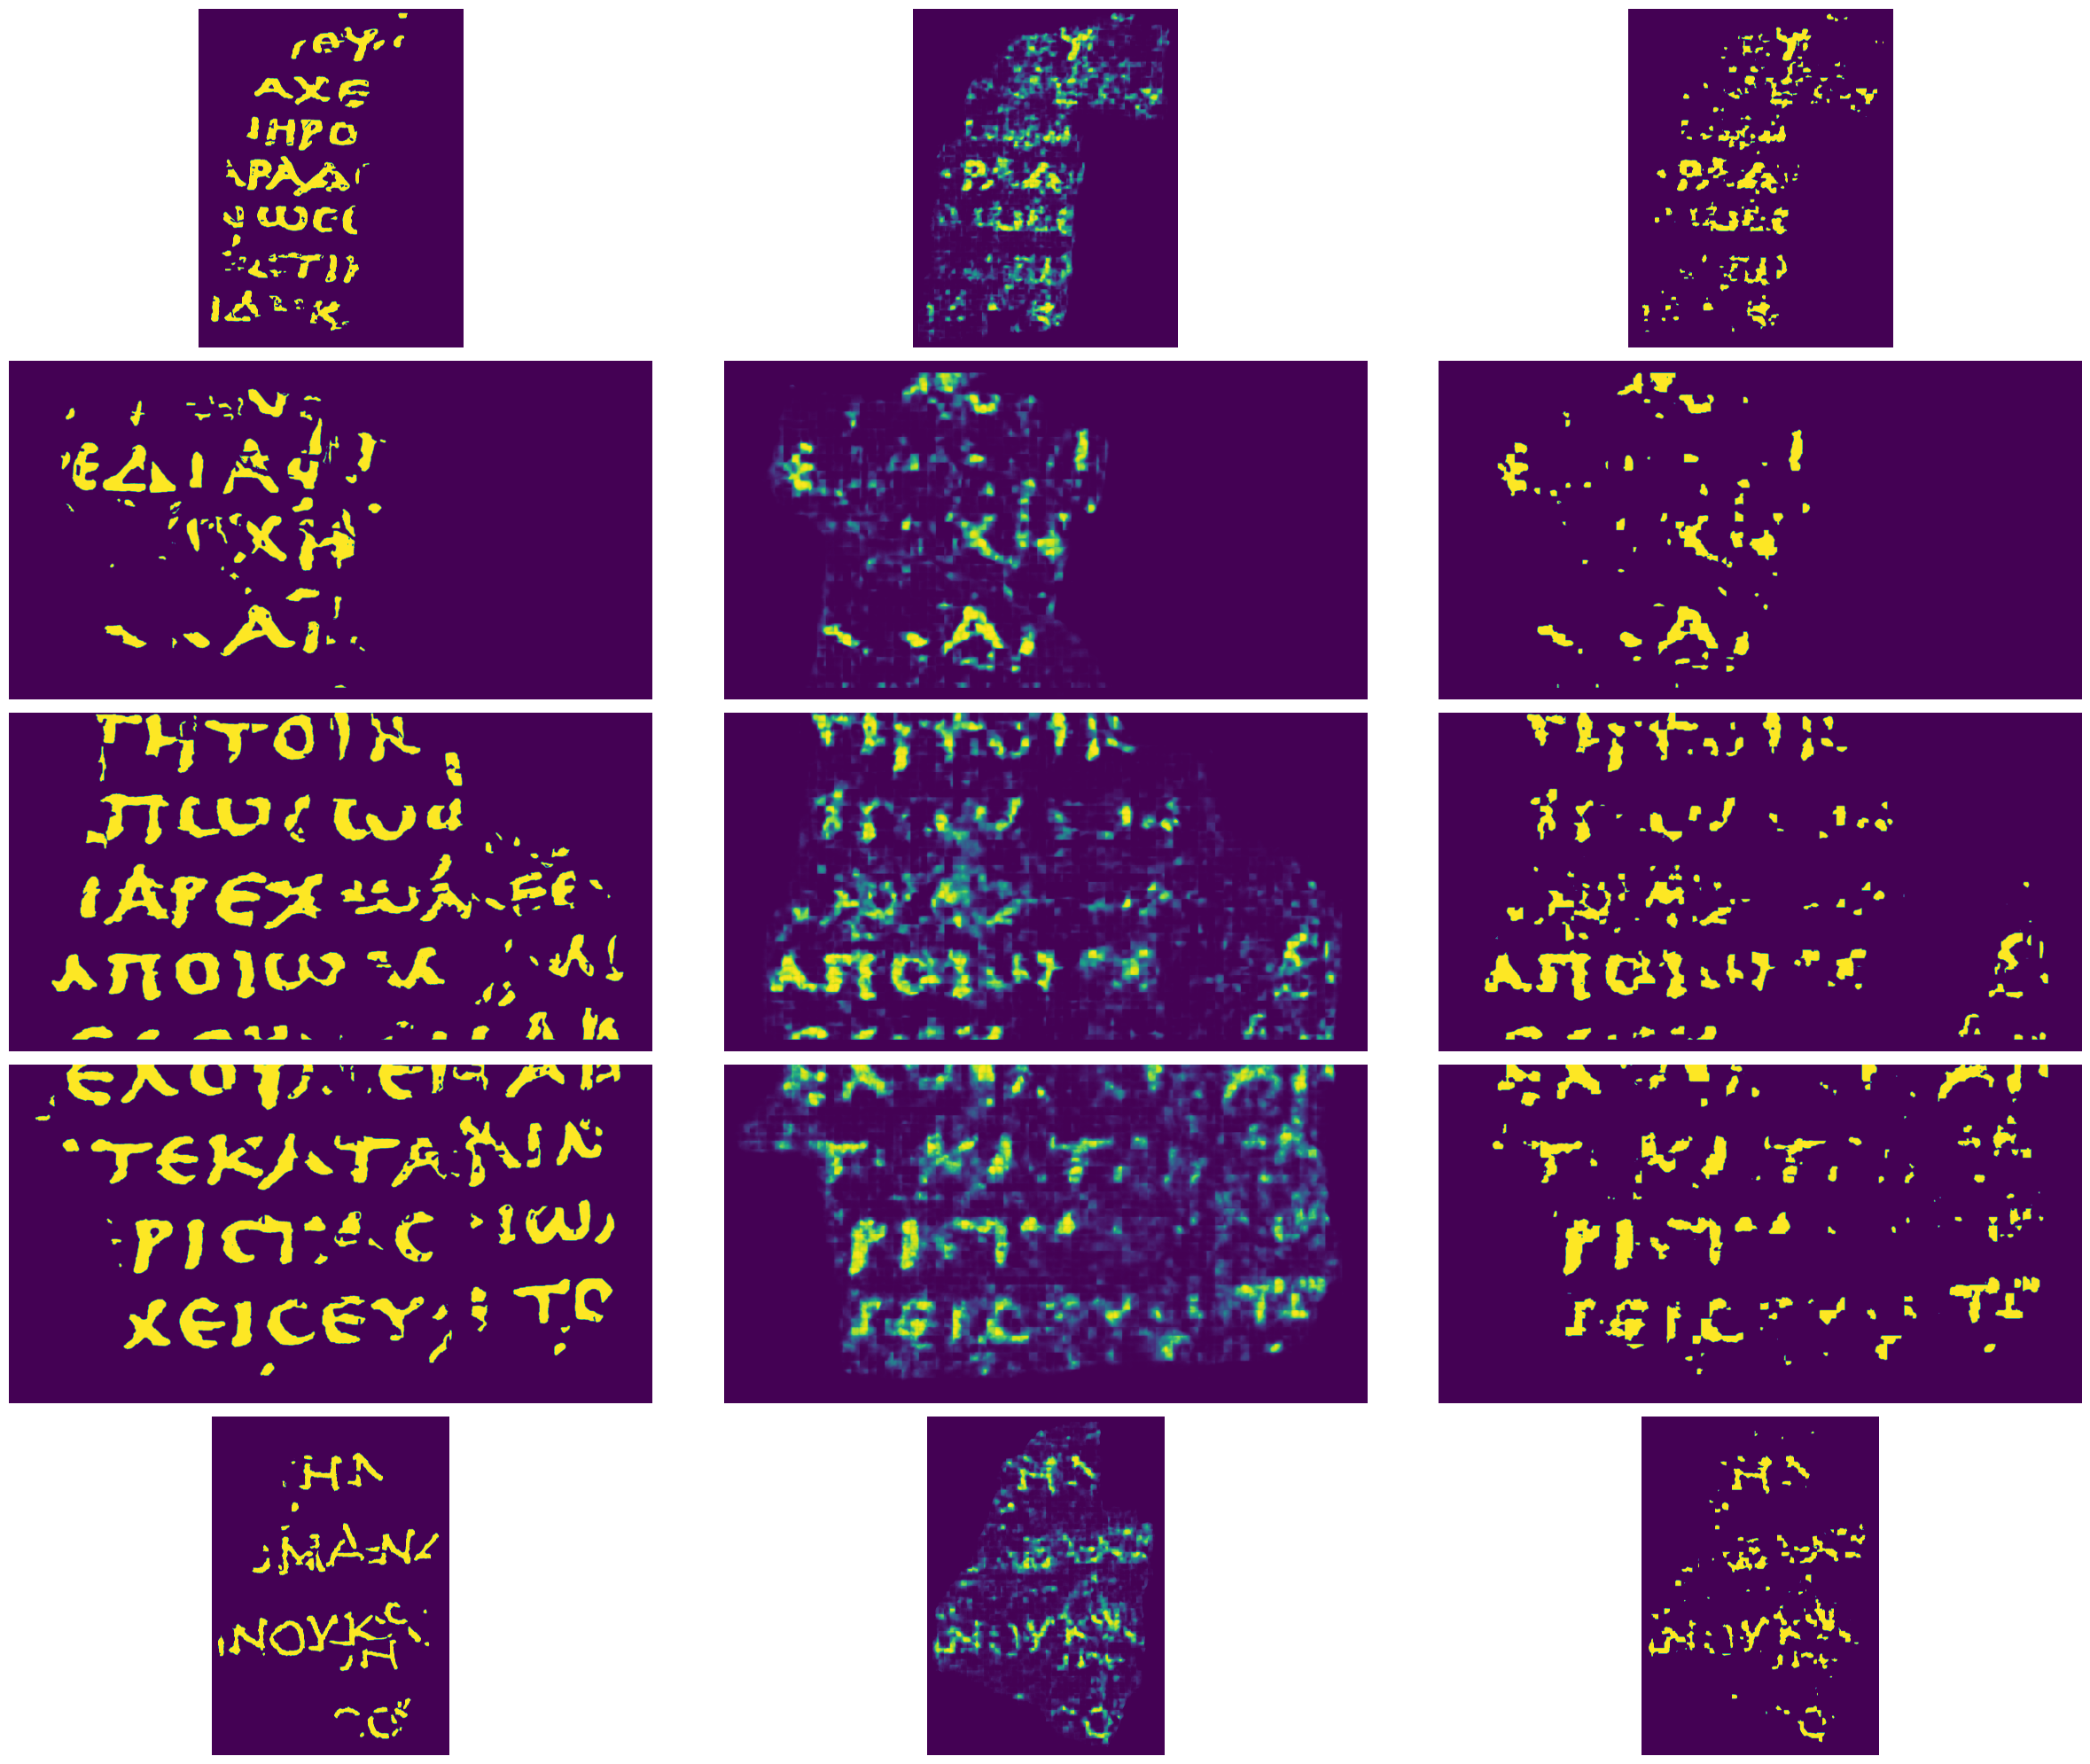

In [10]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)